# Inventory management project

## Data exploration and preparation

### Data loading

In [68]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [69]:
# load data

df_infos = pd.read_csv("infos.csv", sep = "|")
df_items = pd.read_csv("items.csv", sep = "|")
df_orders = pd.read_csv("orders.csv.zip", sep = "|", compression="zip")

### df_orders preparation

In [70]:
# fix datetime format for transaction time

df_orders['time'] = pd.to_datetime(df_orders['time'])

In [71]:
df_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2181955 entries, 0 to 2181954
Data columns (total 5 columns):
 #   Column      Dtype         
---  ------      -----         
 0   time        datetime64[ns]
 1   transactID  int64         
 2   itemID      int64         
 3   order       int64         
 4   salesPrice  float64       
dtypes: datetime64[ns](1), float64(1), int64(3)
memory usage: 83.2 MB


In [72]:
# add one column which is only with the date, no time

df_orders['date'] = df_orders['time'].dt.date

In [73]:
# there seem to be 0 price transactions

len(df_orders[df_orders["salesPrice"]==0])/len(df_orders)*100

# they are 0.02% of all transactions, it is best to delete them instead of thinking how to handle them

df_orders = df_orders[df_orders["salesPrice"]!=0]

In [74]:
# do all items have an order in the period we have?

round(df_orders["itemID"].nunique()/len(df_items)*100, 2)

# 94.05% of all items have an order in the period

94.05

In [75]:
# which transactions are performed on a discounted price?
# we assume the following: a transaction is marked as having a promotion if, for the same item, somewhere else in the table there is
# another transaction performed on a lower price

# Step 1: Get the maximum price per itemID
max_price_per_item = df_orders.groupby('itemID')['salesPrice'].transform('max')

# Step 2: Compare each row's price to the max price for that item
df_orders['promotion'] = df_orders['salesPrice'] < max_price_per_item

# Step 3: Convert boolean to "yes"/"no"
df_orders['promotion'] = df_orders['promotion'].map({True: 1, False: 0})

In [76]:
# this data frame will be aggregared on day level for final use
# so it is best if we continue the transformation in the aggregated version
# but before aggregation, we should check what % of items have been sold on a different price in the same day

price_variations = (
    df_orders
    .assign(date=df_orders['time'].dt.date)
    .groupby(['itemID', 'date'])['salesPrice']
    .nunique()
    .reset_index(name='unique_price_count')
)


# Filter where price count > 1 (i.e., same item sold at multiple prices)
price_variations[price_variations['unique_price_count'] > 1]

,itemID,date,unique_price_count
82,6,2018-05-30,2
188,15,2018-01-27,2
381,27,2018-02-17,2
472,34,2018-05-03,2
521,35,2018-05-25,4
...,...,...,...
99989,10333,2018-06-29,2
99990,10334,2018-06-29,2
100084,10425,2018-06-27,2
100092,10431,2018-05-14,2


In [77]:
# % of such cases from all items

((price_variations[price_variations['unique_price_count'] > 1]['unique_price_count'].count())/len(df_items))*100

14.479594762496417

### df_infos preparation

#### Preparation

In [78]:
# in df_infos column promotion there are cells with more than one date, separated by a comma
# how many such are there?

(df_infos["promotion"].str.len() > 10).sum()

# 190
# I leave it as text for now, we should handle it later

190

In [79]:
df_infos["promotion"][df_infos["promotion"].str.len() > 10]

34       2018-07-01,2018-07-02,2018-07-13
74                  2018-07-05,2018-07-11
124                 2018-07-08,2018-07-13
125                 2018-07-05,2018-07-11
353                 2018-07-08,2018-07-11
                       ...               
9996                2018-07-02,2018-07-05
10093               2018-07-05,2018-07-09
10111    2018-07-04,2018-07-05,2018-07-06
10176               2018-07-01,2018-07-10
10318               2018-07-05,2018-07-06
Name: promotion, Length: 190, dtype: object

In [80]:
# does df_infos, containing the promotions, contain unique item IDs or are they duplicated?
# I expect them to be unique

len(df_infos["itemID"]) == len(df_items)
df_infos["itemID"].value_counts().max() == 1


True

In [81]:
df_infos["itemID"].isin(df_items["itemID"]).count() == len(df_infos["itemID"])

# it contains a row for each itemID

True

#### Deriving discounts for the simulation period

In [82]:
df_orders["maxPrice"] = df_orders.groupby("itemID")["salesPrice"].transform("max")

In [83]:
# how do discounts vary

df_orders["discountAmount"] = round(df_orders["maxPrice"] - df_orders["salesPrice"], 2)

df_orders["discountPerc"] = round(df_orders["discountAmount"]/df_orders["maxPrice"], 2)

In [84]:
# max and min % discount

print(max(df_orders["discountPerc"]), min(df_orders["discountPerc"][df_orders["discountPerc"] != 0]))

0.95 0.01


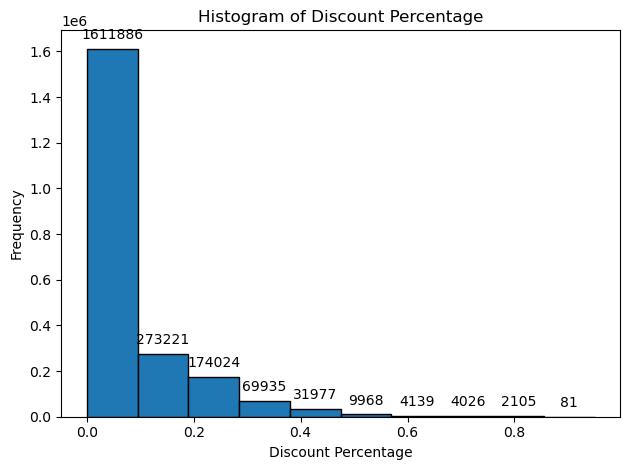

In [85]:
# Create the histogram and get the bars
ax = df_orders["discountPerc"].plot(kind="hist", bins=10, edgecolor='black')

# Add value labels on top of each bar
for patch in ax.patches:
    height = patch.get_height()
    if height > 0:
        ax.annotate(f'{int(height)}', 
                    xy=(patch.get_x() + patch.get_width() / 2, height), 
                    xytext=(0, 5),  # offset
                    textcoords="offset points",
                    ha='center', va='bottom')

plt.xlabel("Discount Percentage")
plt.ylabel("Frequency")
plt.title("Histogram of Discount Percentage")
plt.tight_layout()
plt.show()

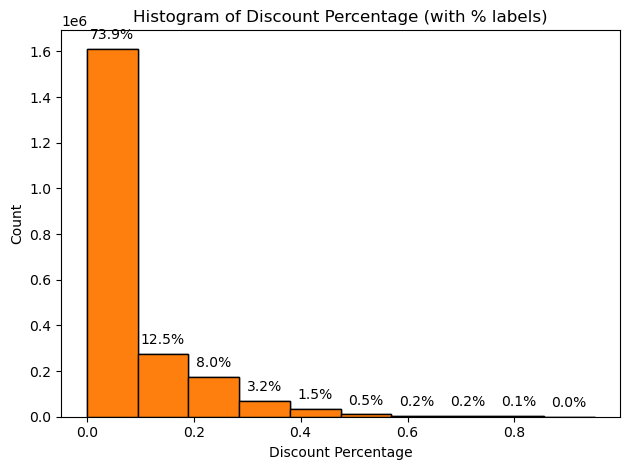

In [86]:
# Total number of observations
total = len(df_orders["discountPerc"].dropna())

# Plot the histogram as density (normalized)
ax = df_orders["discountPerc"].plot(kind="hist", bins=10, edgecolor='black', density=False)

# Get the actual bin heights (counts) to calculate percentages
counts, bins, patches = plt.hist(df_orders["discountPerc"].dropna(), bins=10, edgecolor='black')

# Annotate bars with percentage labels
for count, patch in zip(counts, patches):
    percentage = 100 * count / total
    if count > 0:
        plt.annotate(f'{percentage:.1f}%', 
                     xy=(patch.get_x() + patch.get_width() / 2, count), 
                     xytext=(0, 5),
                     textcoords="offset points",
                     ha='center', va='bottom')

plt.xlabel("Discount Percentage")
plt.ylabel("Count")
plt.title("Histogram of Discount Percentage (with % labels)")
plt.tight_layout()
plt.show()

In [87]:
# looking at the skewed distribution, for getting an approximate discount percentage per item
# it would be better to use the median instead of the mean
# adding column for discounted price to table df_infos = simulation price - median discount for item
# Start with itemID column
df_discount_stats = df_items[["itemID"]].copy()

# Filter out rows where discountAmount is 0
df_nonzero_discounts = df_orders[df_orders["discountAmount"] != 0].copy()

# Drop duplicates to keep only unique discount percentages per item
unique_discounts = df_nonzero_discounts.drop_duplicates(subset=["itemID", "discountPerc"])

# Now compute the median of these unique values per item
median_discounts = (
    unique_discounts
    .groupby("itemID")["discountPerc"]
    .median()
    .round(2)
    .reset_index()
    .rename(columns={"discountPerc": "medianDiscPerc"})
)

# Merge into df_discount_stats
df_discount_stats = df_discount_stats.merge(median_discounts, on="itemID", how="left")



In [88]:
# adding column for discounted price to table df_infos = simulation price - median discount for item

df_infos = df_infos.merge(df_discount_stats[['itemID', 'medianDiscPerc']], on='itemID', how='left')

In [89]:
# adding column for discounted price to table df_infos = simulation price - median discount for item

df_infos["discountedPrice"] = np.where(
    df_infos["promotion"].notna(),
    round(df_infos["simulationPrice"] * (1 - df_infos["medianDiscPerc"]), 2),
    np.nan  # or just leave it to default if you prefer
)


In [90]:
# unfinished - we have to use some mean based on similar items to derive median discount % for items which will have
# a promotion in the simulation period but have not had a discount in the historical data

In [91]:
# adding also min price per item in the orders data frame for completion

df_orders["minPrice"] = df_orders.groupby("itemID")["salesPrice"].transform("min")

#### Quickly check relation - qty sold and promotion

In [92]:
# promo tests

# Step 1: Sum quantity per itemID, date, and promotion (daily sales)
daily_qty = (
    df_orders
    .groupby(['itemID', 'date', 'promotion'])['order']
    .sum()
    .reset_index()
)

# Step 2: Aggregate by itemID and promotion: 
# total quantity sold (sum of daily sums)
# count of days with sales (number of unique days)
agg = daily_qty.groupby(['itemID', 'promotion']).agg(
    total_qty=('order', 'sum'),
    count_days=('date', 'nunique')
).unstack(fill_value=0)

# Step 3: Build the final DataFrame safely extracting promo/no promo columns
summary = pd.DataFrame({
    'QTY_no_promo': agg['total_qty'].get(0, pd.Series(0)),
    'QTY_promo': agg['total_qty'].get(1, pd.Series(0)),
    'count_days_no_promo': agg['count_days'].get(0, pd.Series(0)),
    'count_days_promo': agg['count_days'].get(1, pd.Series(0))
}).reset_index()

# Step 4: Calculate average quantity per day (handle division by zero)
summary['QTY_no_promo_per_day'] = summary.apply(
    lambda r: r['QTY_no_promo'] / r['count_days_no_promo'] if r['count_days_no_promo'] > 0 else 0,
    axis=1
)
summary['QTY_promo_per_day'] = summary.apply(
    lambda r: r['QTY_promo'] / r['count_days_promo'] if r['count_days_promo'] > 0 else 0,
    axis=1
)


In [93]:
# promo tests

len(summary[summary["QTY_promo_per_day"] > summary["QTY_no_promo_per_day"]])/len(summary)

0.20558943089430895

## Aggregate orders

In [94]:
# aggregate df_orders on a daily basis
# sum of QTY
# average of price (or median?)?
# promotion - if 1 is present, then 1 (had at least 1 promotion in that day)
# median discount %?
# median discount amount?

# to make a desicion wether to use mean of median for price, discount amount, discount perc
# we have to look at the distribution of the prices for some items


### Checking price per item distributions

In [95]:
# adding a column with item_prices_count to df_orders

df_orders["item_prices_count"] = df_orders.groupby("itemID")["salesPrice"].transform(lambda x: x.nunique())

In [96]:
# getting a random sample where the item has price discount of > 0.79, meaning there might
# be great price variations of the item

df_sample = df_orders[["itemID"]][df_orders["discountPerc"] > 0.79]

df_sample = df_sample.sample(n=50, random_state=222)

df_sample = df_sample.sort_values(by="itemID", ascending=True)

df_sample = df_sample.merge(df_orders, how="left", on="itemID")

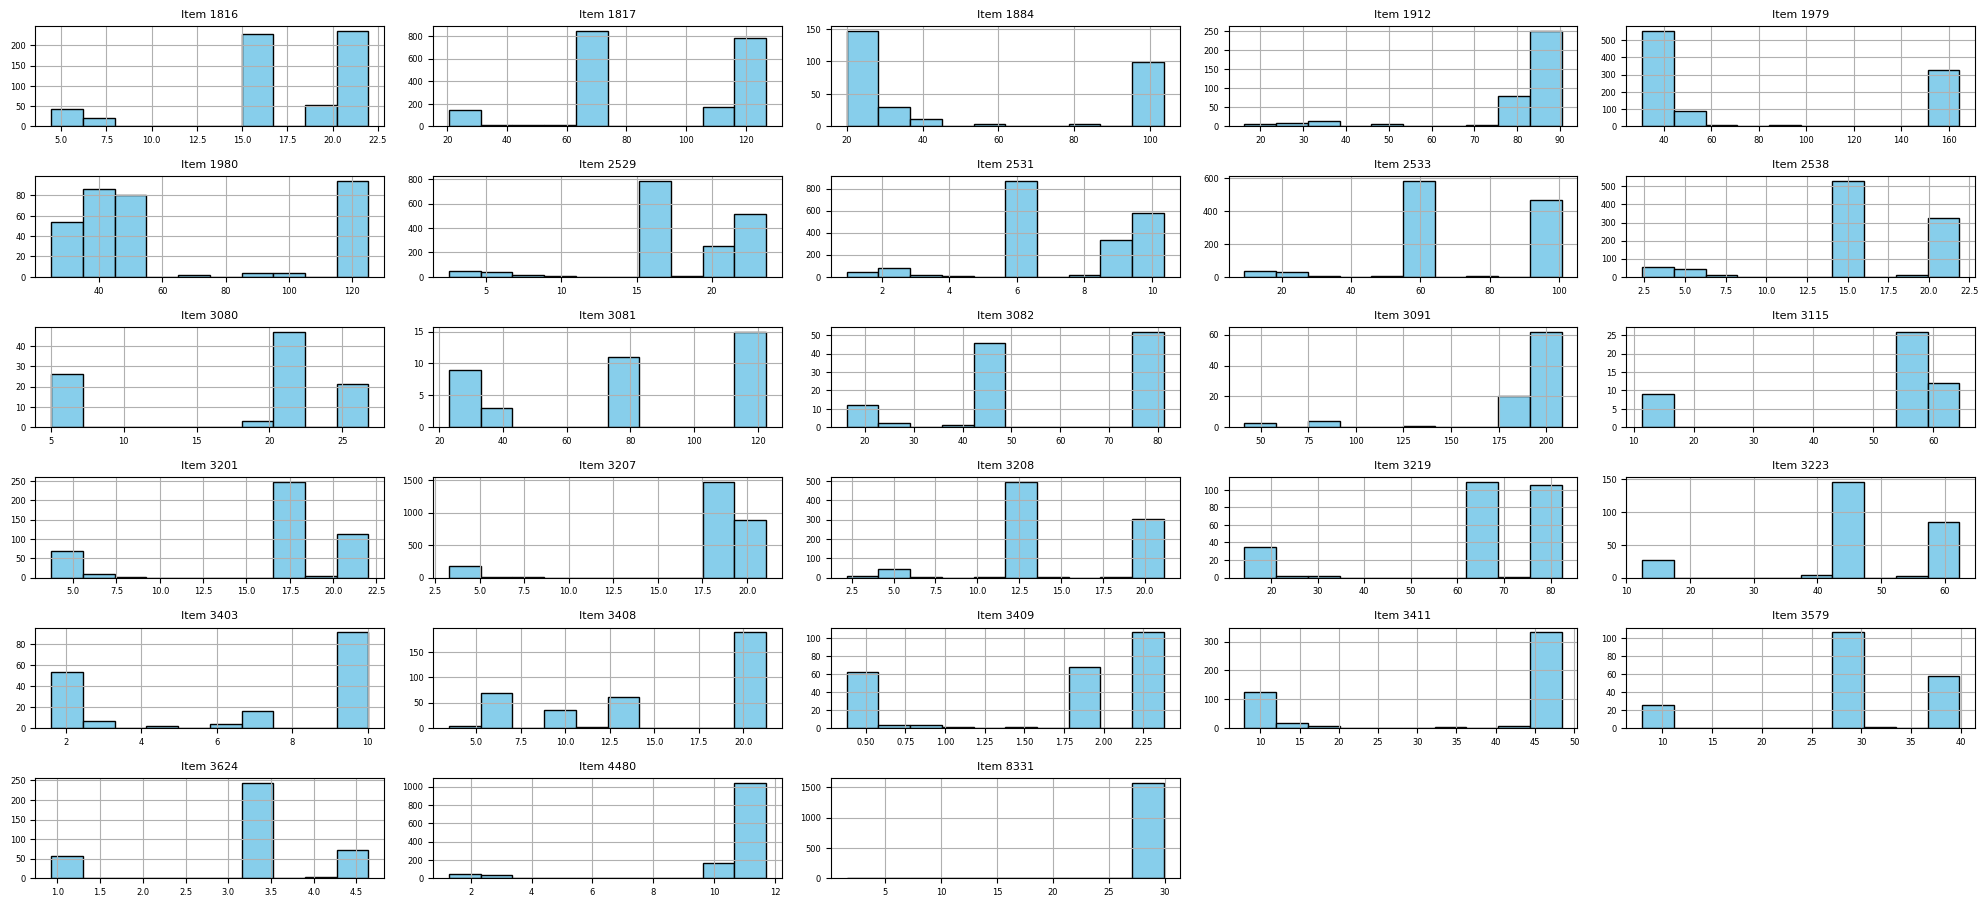

In [97]:
# visualizing 

# Unique items
item_ids = df_sample['itemID'].unique()

# Set up the grid
rows, cols = 10, 5
fig, axes = plt.subplots(rows, cols, figsize=(20, 15), sharex=False, sharey=False)
axes = axes.flatten()

# Plot histogram for each item
for i, item_id in enumerate(item_ids):
    ax = axes[i]
    item_prices = df_sample[df_sample['itemID'] == item_id]['salesPrice']

    ax.hist(item_prices, bins=10, color='skyblue', edgecolor='black')
    ax.set_title(f'Item {item_id}', fontsize=8)
    ax.tick_params(labelsize=6)
    ax.grid(True)

# Hide unused subplots
for j in range(len(item_ids), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [98]:
# it would be useful to see another check to make aa decision
# see the top 10 items for which the mean and median are the most different and
# see which one makes more sence for us

# Group by itemID and compute mean and median
price_stats = df_orders.groupby('itemID')['salesPrice'].agg(
    mean_price='mean',
    median_price='median'
).reset_index()

# Compute absolute difference
price_stats['abs_diff'] = (price_stats['mean_price'] - price_stats['median_price']).abs()

# Compute absolute percentage difference relative to median
price_stats['abs_perc_diff'] = (price_stats['abs_diff'] / price_stats['median_price']).abs() * 100

# Round numerical columns
price_stats[['mean_price', 'median_price', 'abs_diff', 'abs_perc_diff']] = price_stats[
    ['mean_price', 'median_price', 'abs_diff', 'abs_perc_diff']].round(2)

# Sort by absolute percentage difference descending
price_stats = price_stats.sort_values(by='abs_perc_diff', ascending=False)

In [99]:
# now look at histograms of top 50 of items with most % difference of mean and median

df_sample = price_stats.sort_values(by='abs_perc_diff', ascending=False).head(50)[["itemID"]]

df_sample = df_sample.sample(n=50, random_state=222)

df_sample = df_sample.sort_values(by="itemID", ascending=True)

df_sample = df_sample.merge(df_orders, how="left", on="itemID")

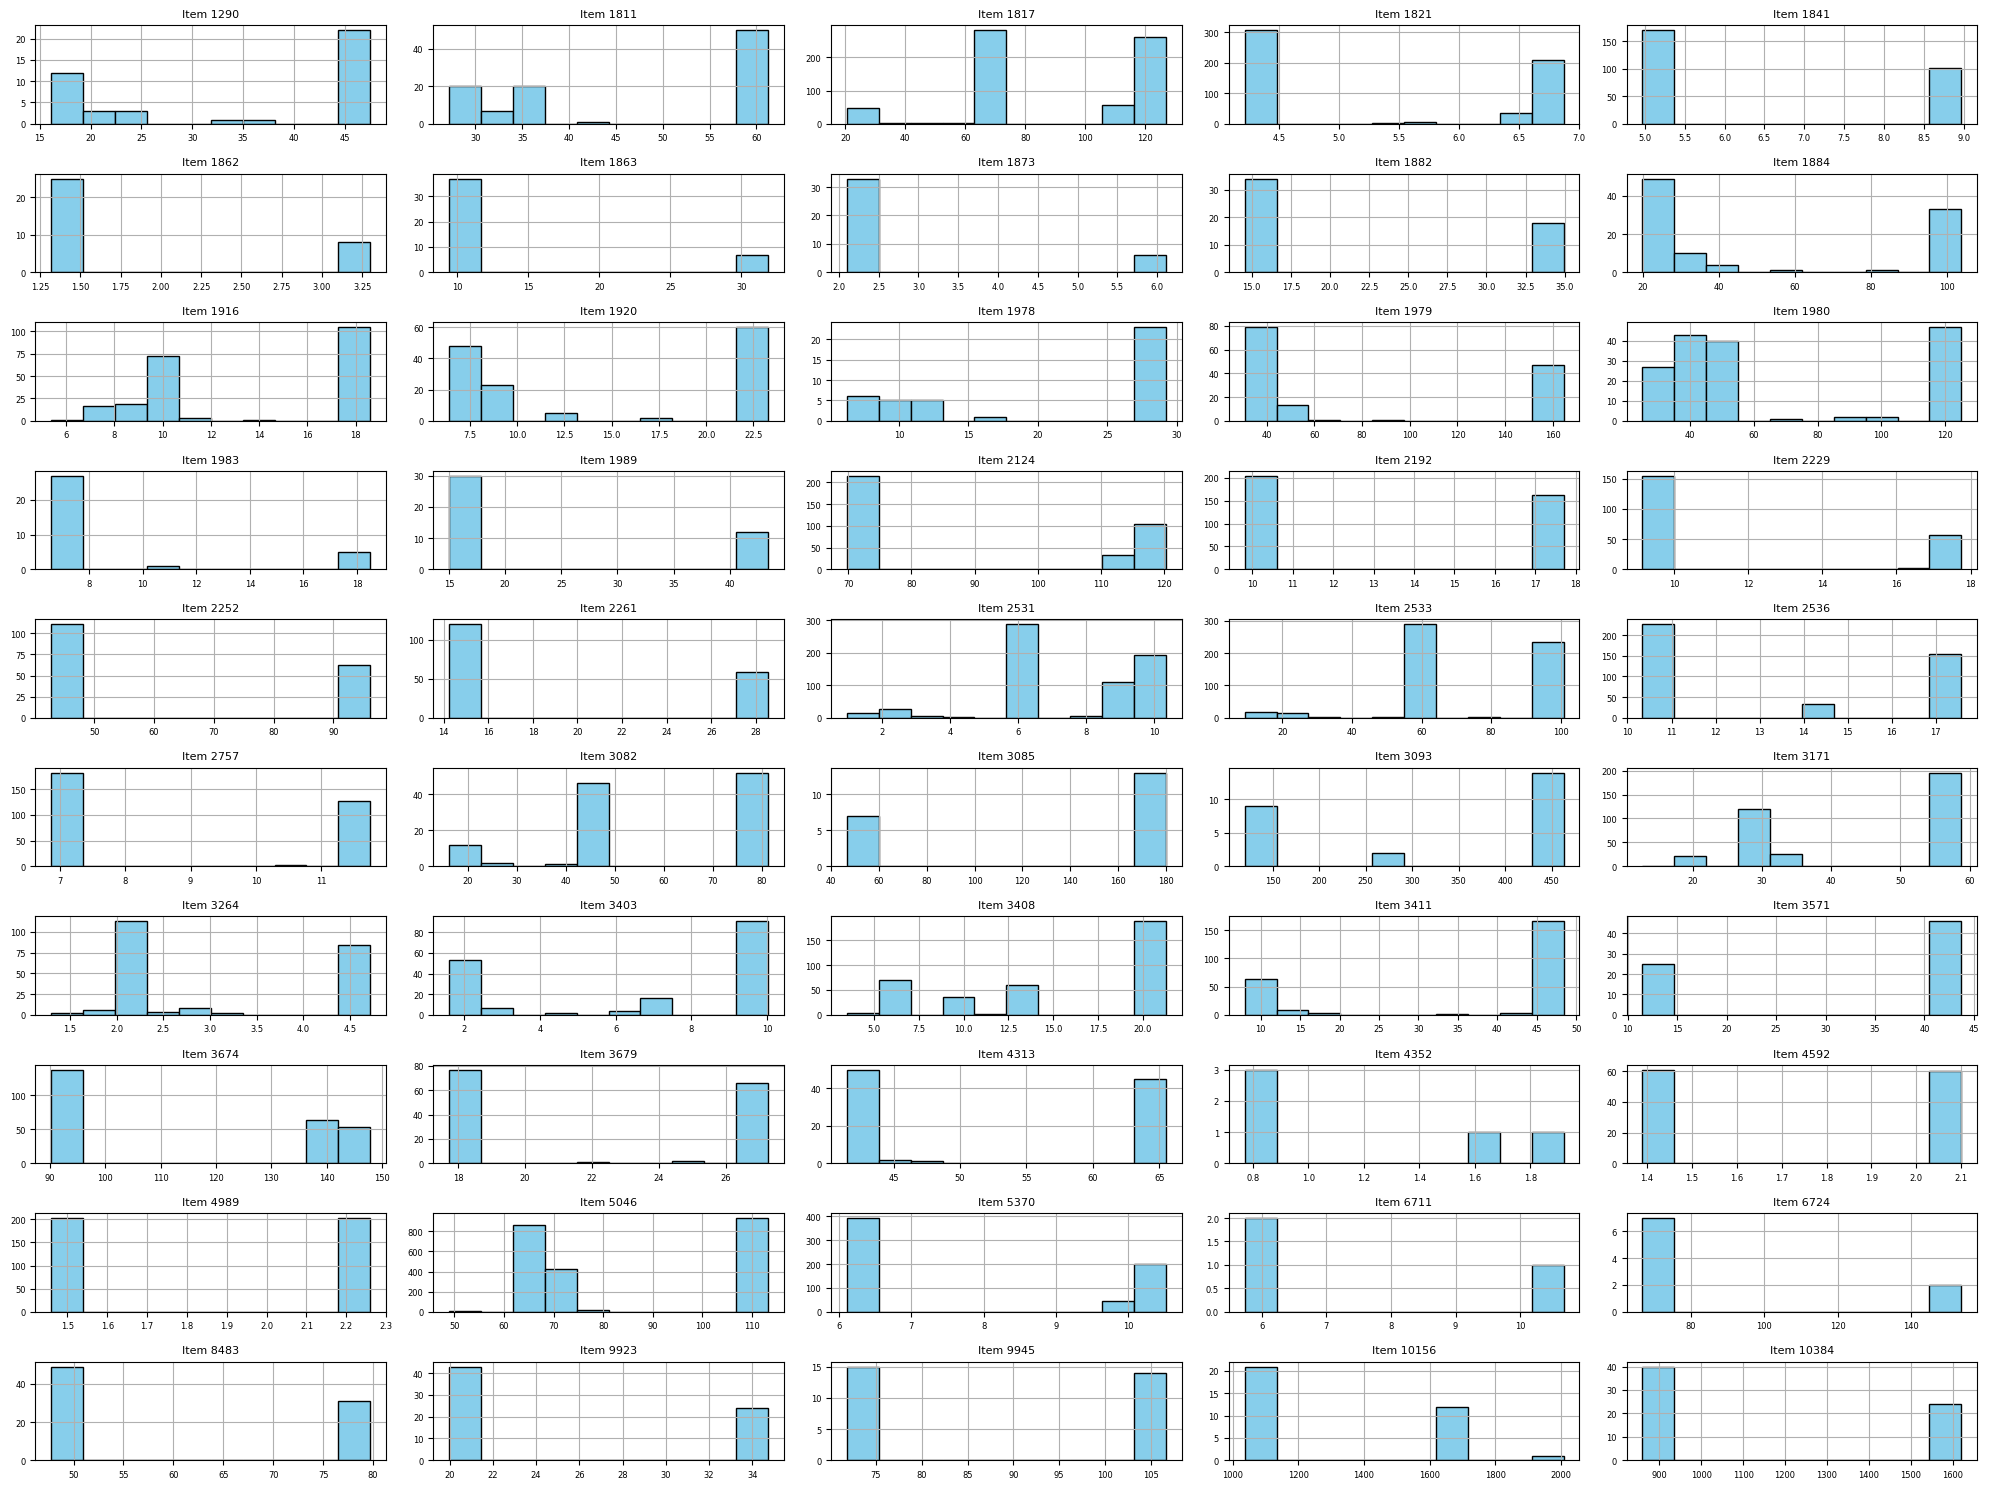

In [ ]:
# visualizing 

# Unique items
item_ids = df_sample['itemID'].unique()

# Set up the grid
rows, cols = 10, 5
fig, axes = plt.subplots(rows, cols, figsize=(20, 15), sharex=False, sharey=False)
axes = axes.flatten()

# Plot histogram for each item
for i, item_id in enumerate(item_ids):
    ax = axes[i]
    item_prices = df_sample[df_sample['itemID'] == item_id]['salesPrice']

    ax.hist(item_prices, bins=10, color='skyblue', edgecolor='black')
    ax.set_title(f'Item {item_id}', fontsize=8)
    ax.tick_params(labelsize=6)
    ax.grid(True)

# Hide unused subplots
for j in range(len(item_ids), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [ ]:
# it is better to use mean because the extreme values are not a one-case accidental thing

In [ ]:
# aggregate using mean (average), but specifically weighted average, to gain price per each
# weighted average will take into account how accidental the outlier prices were

### Aggregate orders on day level

In [103]:
# in order to get weighted average price per each for the items
# first we need to add a column to df_orders
# with order value = qty * price

df_orders["orderValue"] = df_orders["order"] * df_orders["salesPrice"]

In [106]:
# aggregating on day level

df_orders_daily = df_orders.groupby(['date', 'itemID']).agg(
    qty_sold=('order', 'sum'),
    sales_value=('orderValue', 'sum'),
    promotion=('promotion', 'max'),  # If any transaction had promotion == 1, result will be 1
    maxItemPrice=('maxPrice', 'max'), # doesn't matter min or max - its the same value for all transactions with the same item
    minItemPrice=('minPrice', 'max') # doesn't matter min or max - its the same value for all transactions with the same item
).reset_index()

In [109]:
# deriving price per each for the items

df_orders_daily["TotalItemQty"] = df_orders_daily.groupby("itemID")["qty_sold"].transform("sum")
df_orders_daily["TotalItemValue"] = df_orders_daily.groupby("itemID")["sales_value"].transform("sum")

df_orders_daily["PricePerEach"] = round(df_orders_daily["TotalItemValue"] / df_orders_daily["TotalItemQty"], 2)

df_orders_daily = df_orders_daily.drop(['TotalItemQty', 'TotalItemValue'], axis=1)

In [114]:
# add median discout for the items
# we have it currently for each item in df_infos

# Select only itemID and medianDiscount from df_infos and merge on itemID
df_orders_daily = df_orders_daily.merge(
    df_infos[["itemID", "medianDiscPerc"]],
    how="left",
    on="itemID"
)

## Feature engineering